# Postprocessing a DeepONet Trained for a Mass-Spring-Damper System 

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from tensorflow                           import keras

import romnet                             as rmnt

In [2]:
### Defining ODE and its Parameters

from scipy.integrate import solve_ivp

def fOrig(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Source(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

Params = np.array([1.0, 0.5, 3.0], dtype=np.float64)

In [3]:
### Input Data

ROMNetFldr    = WORKSPACE_PATH + '/ROMNet/romnet/'
PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_100Cases_All/DeepONet_BbB/Deterministic/Run_3/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/DeepONet/MCDropOut/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/DeepONet/BayesByBackprop/Run_2/'

TrainingCases = [0]#[0,2,4,6,8]
TestCases     = [0,2,4]#[0,2]

NSamples      = 100

Nt            = 100
tout          = np.linspace(0.,20.,Nt)
SOLVER        = 'Radau'

LineTypeVec   = ['-',':','--','.-']*10

In [4]:
print("\n[ROMNet]: Reading Input File from: ", PathToRunFld)
sys.path.insert(0, PathToRunFld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH, ROMNetFldr)


InputData.InputFilePath = PathToRunFld+'/ROMNet_Input.py'
InputData.TrainIntFlg   = 0
InputData.PathToRunFld  = PathToRunFld


[ROMNet]: Reading Input File from:  /Users/sventuri/WORKSPACE//ROMNet/MSD_100Cases_All/DeepONet_BbB/Deterministic/Run_3/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


In [5]:
SurrogateType = InputData.SurrogateType
if (SurrogateType == 'FNN-SourceTerms'):
    SurrogateType = 'FNN'

Net   = getattr(rmnt.nn, SurrogateType)

model = rmnt.model.Model_Deterministic(InputData)

model.build(InputData, None, Net)#, loadfile_no='000001')

NN    = model.net


[ROMNet]:   Initializing the ML Model

[ROMNet]:   Building the ML Model





[ROMNet]:   Loading ML Model Parameters from File:  /Users/sventuri/WORKSPACE//ROMNet/MSD_100Cases_All/DeepONet_BbB/Deterministic/Run_3//Training/Params//000010.h5
'load_params' took 0.100461 s


[ROMNet]:   Saving ML Model Parameters to File:  /Users/sventuri/WORKSPACE//ROMNet/MSD_100Cases_All/DeepONet_BbB/Deterministic/Run_3//Model/Params/Initial.h5
'save_params' took 0.089796 s

'build' took 5.151952 s



In [6]:
# LName   = 'Trunk_1_HL' + str(len(InputData.TrunkActFun[0]))

# Trunk = keras.Model(NN.inputs, NN.get_layer(LName).output)
# Trunk.summary()

In [7]:
# LName   = 'Branch_'+InputData.BranchVars[0]+'_HL' + str(len(InputData.TrunkActFun[0]))
# '_HL' + str(len(InputData.BranchActFun[0]))

# Branch1 = keras.Model(NN.Model.inputs, NN.Model.get_layer(LName).output)
# Branch1.summary()

In [8]:
# LName   = 'Branch_'+InputData.BranchVars[1]+'_HL' + str(len(InputData.BranchActFun[1]))

# Branch2 = keras.Model(NN.Model.inputs, NN.Model.get_layer(LName).output)
# Branch2.summary()

In [9]:
# ### Evaluating on Training Data

# FileName  = InputData.PathToDataFld + '/' + InputData.InputFile
# Data      = pd.read_csv(FileName, header=0)
# Input     = Data[InputData.BranchVars].to_numpy()
# VarNames  = list(Data.columns)
# Nu        = Input.shape[1]
# u         = []
# for iu in range(Nu):
#     u.append(np.unique(Input[:,iu]))
# u         = np.stack(u, axis=0).T


# ## Variable to Be Visualized
# VarOI     = 'x'
# for iVar in range(1,len(VarNames)):
#     if (VarNames[iVar] == VarOI):
#         print('iVar = ', iVar)
#         break

        
# for iTraining in TrainingCases:

#     print('u0 = ', u[iTraining,:])

#     ### Generating Data  
#     output     = solve_ivp( fOrig, tout[[0,-1]], u[iTraining,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
#     tOrig      = tout
#     yMatOrig   = output.y.T
    
#     ### Creating NN Input
#     tPred     = tOrig[...,np.newaxis]
#     Nt        = len(tPred)
#     uPred     = u[iTraining,:]*np.ones((Nt,2))
#     InputPred = np.concatenate((uPred,tPred), axis=1)
    
#     if (InputData.ProbApproach == 'Deterministic') or (NSamples == 1):
    
#         yMat       = NN.predict(InputPred)    
#         yTrunk     = Trunk.predict(InputPred)
        
#         ## Plotting
#         fig = plt.figure(figsize=(16, 12))
#         plt.plot(tOrig, yMatOrig[:,iVar-1],  'k-', label='Data')
#         plt.plot(tPred, yMat[:,iVar-1],      'b-', label='DeepONet')
#         plt.xlabel('t')
#         plt.ylabel(VarOI)
#         plt.legend()
#         plt.show()
        
#     else:
        
#         ### Sampling NN
#         yMat_sum   = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))
#         yMat_sqr   = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))
#         yTrunk_sum = np.zeros((yMatOrig.shape[0], 32))
#         yTrunk_sqr = np.zeros((yMatOrig.shape[0], 32))

#         for iSample in range(NSamples):
#             yMat      = NN.predict(InputPred)    
#             yMat_sum += yMat
#             yMat_sqr += yMat**2

#             yTrunk      = Trunk.predict(InputPred)
#             yTrunk_sum += yTrunk
#             yTrunk_sqr += yTrunk**2

#         yTrunk_mean = yTrunk_sum/NSamples
#         yTrunk_std  = np.sqrt( yTrunk_sqr/NSamples - yTrunk_mean**2 )
#         yTrunk_p1   = yTrunk_mean + 1.*yTrunk_std
#         yTrunk_m1   = yTrunk_mean - 1.*yTrunk_std
#         yTrunk_p2   = yTrunk_mean + 2.*yTrunk_std
#         yTrunk_m2   = yTrunk_mean - 2.*yTrunk_std
#         yTrunk_p3   = yTrunk_mean + 3.*yTrunk_std
#         yTrunk_m3   = yTrunk_mean - 3.*yTrunk_std


#         yMat_mean = yMat_sum/NSamples
#         yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
#         yMat_p1   = yMat_mean + 1.*yMat_std
#         yMat_m1   = yMat_mean - 1.*yMat_std
#         yMat_p2   = yMat_mean + 2.*yMat_std
#         yMat_m2   = yMat_mean - 2.*yMat_std
#         yMat_p3   = yMat_mean + 3.*yMat_std
#         yMat_m3   = yMat_mean - 3.*yMat_std


#         ## Plotting
#         fig = plt.figure(figsize=(16, 12))
#         plt.plot(tOrig, yMatOrig[:,iVar-1],  'k-', label='Data')
#         plt.plot(tPred, yMat_mean[:,iVar-1], 'b-', label=r'DeepONet, $\mu$')
#         plt.plot(tPred, yMat_p3[:,iVar-1],   'b:', label=r'DeepONet, $\mu+3\sigma$')
#         plt.plot(tPred, yMat_m3[:,iVar-1],   'b:', label=r'DeepONet, $\mu-3\sigma$')
#         plt.xlabel('t')
#         plt.ylabel(VarOI)
#         plt.legend()
#         plt.show()

In [10]:
# ### Evaluating Trunk's Last Layer on Training Data

# ## Neuron of Interest for Trunk's Last Layer
# iN  = 4

# if (InputData.ProbApproach == 'Deterministic') or (NSamples == 1):
    
#     fig = plt.figure(figsize=(16, 12))
#     plt.plot(tPred, yTrunk[:,iN], 'b-', label=r'TrunkNet')
#     plt.xlabel('t')
#     plt.ylabel(VarOI)
#     plt.legend()
#     plt.show()
    
# else:
    
#     fig = plt.figure(figsize=(16, 12))
#     plt.plot(tPred, yTrunk_mean[:,iN], 'b-', label=r'TrunkNet, $\mu$')
#     plt.plot(tPred, yTrunk_p3[:,iN],   'b:', label=r'TrunkNet, $\mu+3\sigma$')
#     plt.plot(tPred, yTrunk_m3[:,iN],   'b:', label=r'TrunkNet, $\mu-3\sigma$')
#     plt.xlabel('t')
#     plt.ylabel(VarOI)
#     plt.legend()
#     plt.show()

In [11]:
FileName  = '/Users/sventuri/WORKSPACE/ROMNet/Data/MSD_100Cases/Orig/test/ext/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Input     = Data[InputData.BranchVars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T
u

array([[-3.6, -3.6],
       [-2.8, -2.8],
       [-2. , -2. ],
       [-1.2, -1.2],
       [-0.4, -0.4],
       [ 0.4,  0.4],
       [ 1.2,  1.2],
       [ 2. ,  2. ],
       [ 2.8,  2.8],
       [ 3.6,  3.6]])

iVar =  1
u0 =  [-3.6 -3.6]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))






u0 =  [-2.8 -2.8]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


u0 =  [-2. -2.]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


u0 =  [-1.2 -1.2]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


u0 =  [-0.4 -0.4]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


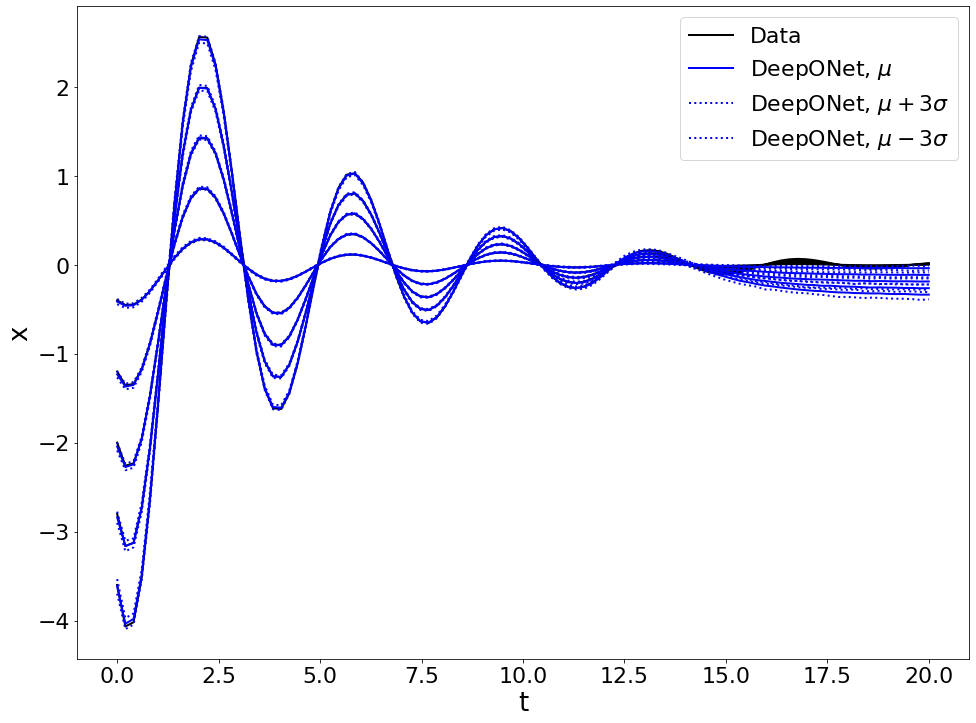

In [12]:
### Evaluating on Test Data

FileName  = '/Users/sventuri/WORKSPACE/ROMNet/Data/MSD_100Cases/Orig/test/ext/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Input     = Data[InputData.BranchVars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T


## Variable to Be Visualized
VarOI     = 'x'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break

iSim = 0
for iTest in [0,1,2,3,4]:
    
    print('u0 = ', u[iTest,:])

    ### Generating Data  
    output     = solve_ivp( fOrig, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    tOrig      = tout
    yMatOrig   = output.y.T
    
    ### Creating NN Input
    tPred     = tOrig[...,np.newaxis]
    Nt        = len(tPred)
    uPred     = u[iTest,:]*np.ones((Nt,2))
    InputPred = np.concatenate((uPred,tPred), axis=1)
    
    if (InputData.ProbApproach == 'Deterministic') and (NSamples == 1):
        
        yMat      = NN.predict(InputPred) 
        
#         tLoop         = np.linspace(0.,15.,10)
#         yMatLoop      = np.zeros((len(tLoop),2))
#         InputPredLoop = np.concatenate([uPred[0,:][np.newaxis,...], (tLoop[0])[np.newaxis,np.newaxis]], axis=1)
#         yMatLoop[0,:] = NN.predict(InputPredLoop)
#         for it, tLoop_ in enumerate(tLoop[1:]):
#             InputPredLoop    = np.concatenate([yMatLoop[it,:][np.newaxis,...], (tLoop[it+1]-tLoop[it])[np.newaxis,np.newaxis]], axis=1)
#             yMatLoop[it+1,:] = NN.predict(InputPredLoop)
        
        ## Plotting
        
        if (iSim == 0):
            fig    = plt.figure(figsize=(16, 12))
            Label1 = 'Data'
            Label2 = 'DeepONet'
            Label3 = 'DeepONet, Iterative'
        else:
            Label1 = None
            Label2 = None
            Label3 = None
    
        plt.plot(tOrig, yMatOrig[:,iVar-1],  'k', label=Label1)
        plt.plot(tPred, yMat[:,iVar-1],      'r', label=Label2)
        #plt.plot(tLoop, yMatLoop[:,iVar-1],  'ob', label=Label3)
        plt.xlabel('t')
        plt.ylabel(VarOI)
        plt.legend()
        #plt.show()
        
    else:
        
        if (iSim == 0):
            fig    = plt.figure(figsize=(16, 12))
            Label1 = 'Data'
            Label2 = r'DeepONet, $\mu$'
            Label3 = r'DeepONet, $\mu+3\sigma$'
            Label4 = r'DeepONet, $\mu-3\sigma$'
        else:
            Label1 = None
            Label2 = None
            Label3 = None
            Label4 = None

        ### Sampling NN
        yMat_sum = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))
        yMat_sqr = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))

        for iSample in range(NSamples):
            yMat_ = NN.predict(InputPred)    
            yMat_sum += yMat_
            yMat_sqr += yMat_**2

        yMat_mean = yMat_sum/NSamples
        yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
        yMat_p1   = yMat_mean + 1.*yMat_std
        yMat_m1   = yMat_mean - 1.*yMat_std
        yMat_p2   = yMat_mean + 2.*yMat_std
        yMat_m2   = yMat_mean - 2.*yMat_std
        yMat_p3   = yMat_mean + 3.*yMat_std
        yMat_m3   = yMat_mean - 3.*yMat_std


        ## Plotting
        plt.plot(tOrig, yMatOrig[:,iVar-1],  'k-', label=Label1)
        plt.plot(tPred, yMat_mean[:,iVar-1], 'b-', label=Label2)
        plt.plot(tPred, yMat_p3[:,iVar-1],   'b:', label=Label3)
        plt.plot(tPred, yMat_m3[:,iVar-1],   'b:', label=Label4)
        plt.xlabel('t')
        plt.ylabel(VarOI)
        plt.legend()
        #plt.show()
        
    iSim += 1

In [13]:
### Evaluating on Test Data

FileName  = '/Users/sventuri/WORKSPACE/ROMNet/Data/MSD_100Cases/Orig/test/ext/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Input     = Data[InputData.BranchVars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T


import time

In [14]:
CostVec_Int = []

iSim = 0
for iTest in [0,1,2,3,4]:
    
    print('u0 = ', u[iTest,:])
    
    t0 = time.time()
    ### Generating Data  
    output     = solve_ivp( fOrig, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    t1 = time.time()
    CostVec_Int.append(t1-t0)
    

    iSim += 1

u0 =  [-3.6 -3.6]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


u0 =  [-2.8 -2.8]
u0 =  [-2. -2.]
u0 =  [-1.2 -1.2]
u0 =  [-0.4 -0.4]


u0 =  [-3.6 -3.6]


No handles with labels found to put in legend.


u0 =  [-2.8 -2.8]


No handles with labels found to put in legend.


u0 =  [-2. -2.]


No handles with labels found to put in legend.


u0 =  [-1.2 -1.2]


No handles with labels found to put in legend.


u0 =  [-0.4 -0.4]


No handles with labels found to put in legend.


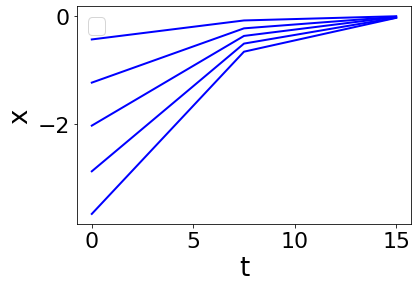

In [15]:
CostVec_Loop = []

iTestVec     = [0,1,2,3,4]

tLoop        = np.linspace(0.,15.,3)

iSim = 0
for iTest in iTestVec:
    
    print('u0 = ', u[iTest,:])
    
    t0 = time.time()
    yMatLoop      = np.zeros((len(tLoop),2))
    InputPredLoop = np.concatenate([u[iTest,:][np.newaxis,...], (tLoop[0])[np.newaxis,np.newaxis]], axis=1)
    yMatLoop[0,:] = NN.predict(InputPredLoop)
    for it, tLoop_ in enumerate(tLoop[1:]):
        InputPredLoop    = np.concatenate([yMatLoop[it,:][np.newaxis,...], (tLoop[it+1]-tout[it])[np.newaxis,np.newaxis]], axis=1)
        yMatLoop[it+1,:] = NN.predict(InputPredLoop)

    t1 = time.time()
    CostVec_Loop.append(t1-t0)
    
    plt.plot(tLoop, yMatLoop[:,iVar-1], 'b')
    plt.xlabel('t')
    plt.ylabel(VarOI)
    plt.legend()
    #plt.show()
    
    iSim += 1

In [16]:
Cost_Loop     = 0.

iTestVec      = [0,1,2,3,4]*10
NTest         = len(iTestVec)
    


InputPredLoop = np.concatenate([u[iTestVec,:], np.array([tLoop[0]]*NTest)[...,np.newaxis]], axis=1)
yMatLoop      = NN.predict(InputPredLoop)
yMatLoopAll   = []
for it, tLoop_ in enumerate(tLoop[1:]):
    InputPredLoop = np.concatenate([yMatLoop, np.array([tLoop[it+1]-tLoop[it]]*NTest)[...,np.newaxis]], axis=1)
    t0            = time.time()
    yMatLoop      = NN.predict(InputPredLoop)
    t1            = time.time()
    Cost_Loop    += t1-t0
    yMatLoopAll.append(yMatLoop)



In [17]:
CostVec_Int

[2.086637020111084,
 1.8328578472137451,
 1.7904069423675537,
 1.6355969905853271,
 1.2148089408874512]

In [18]:
CostVec_Loop

[0.25275111198425293,
 0.2741050720214844,
 0.2876911163330078,
 0.3008401393890381,
 0.2728908061981201]

In [19]:
Cost_Loop

0.15769195556640625

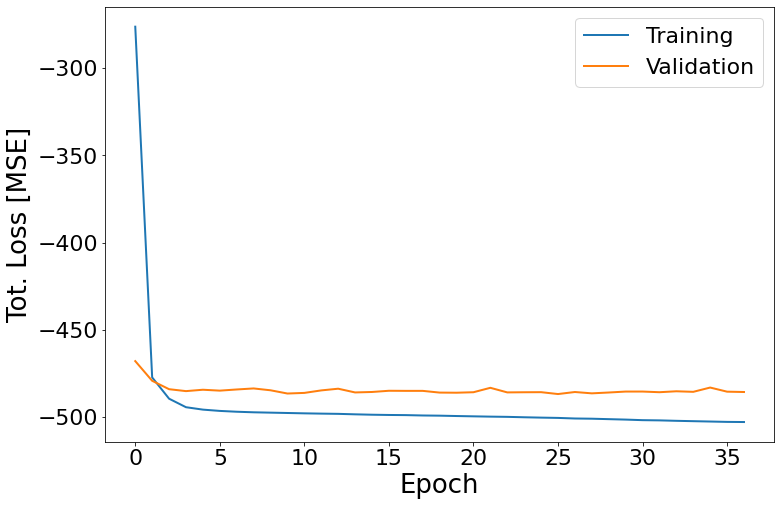

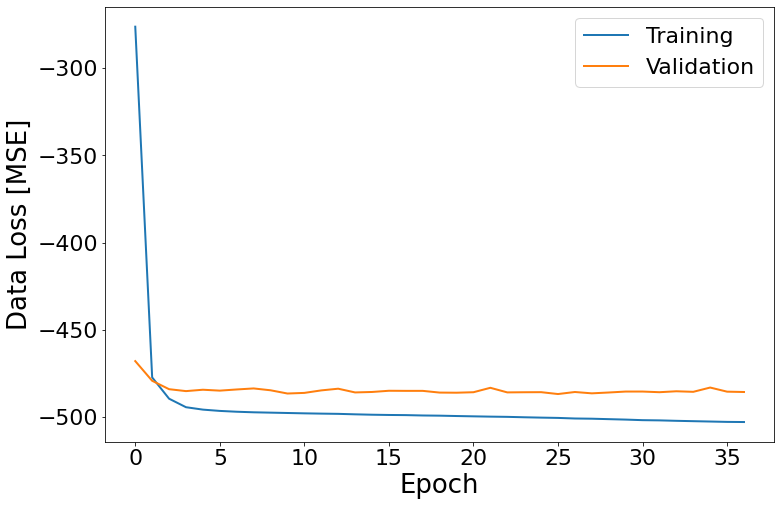

In [20]:
Data = pd.read_csv(PathToRunFld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
#plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
#plt.yscale('log')
#plt.ylim([1.e-2, 1.e0])
# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

In [21]:
FileName   = InputData.PathToDataFld + '/test/ext/Input.csv'# + InputData.InputFile
DataIn     = pd.read_csv(FileName, header=0)
Input_     = DataIn[['x','v','t']].to_numpy()
VarNames   = list(DataIn.columns)

FileName   = InputData.PathToDataFld + '/test/ext/Output.csv'# + InputData.InputFile
Data       = pd.read_csv(FileName, header=0)
Output_    = Data.to_numpy()

In [22]:
import tensorflow as tf

In [23]:
training = False

inputs                    = tf.keras.Input(shape=(3,))
inputsBranch, inputsTrunk = tf.split(inputs, num_or_size_splits=[len(model.net.BranchVars), len(model.net.TrunkVars)], axis=1)


TrunkVec_Sigma = []
for iTrunk in range(model.net.NTrunks):

    y = inputsTrunk
    for f in model.net.TrunkLayersVecs_Sigma[iTrunk]:
        if ('dropout' in f.name):
            y = f(y, training=(training or model.net.TrunkDropOutPredFlg))
        else:
            y = f(y, training=training)
    TrunkVec_Sigma.append(y)
    
    
    
OutputVec_Sigma = []
for iy in range(model.net.NVarsy):
    iTrunk = model.net.BranchToTrunk[iy]

    y      = inputsBranch
    for f in model.net.BranchLayersVecs_Sigma[iy]:
        if ('dropout' in f.name):
            y = f(y, training=(training or model.net.BranchDropOutPredFlg))
        else:
            y = f(y, training=training)
    OutputP_Sigma   = rmnt.nn.deeponet_bbb.Dot_Add(axes=1, n_out=model.net.NDot)([y, TrunkVec_Sigma[iTrunk]])
    
    if (model.net.FinalLayerFlg):
        OutputF_Sigma   = model.net.FinalLayersVecs_Sigma[iy](OutputP_Sigma, training=training)
    else:
        OutputF_Sigma   = OutputP_Sigma
    
    OutputS_Sigma   = 1e-8 + tf.math.softplus(0.05 * OutputF_Sigma)
    
    OutputVec_Sigma.append(OutputS_Sigma)
    
    if (model.net.NVarsy > 1):
        OutputConcat_Sigma = tf.keras.layers.Concatenate(axis=1)(OutputVec_Sigma)
    else:
        OutputConcat_Sigma = OutputVec_Sigma[0]
        

        
Sigmas = keras.Model(inputs=inputs, outputs=OutputConcat_Sigma)

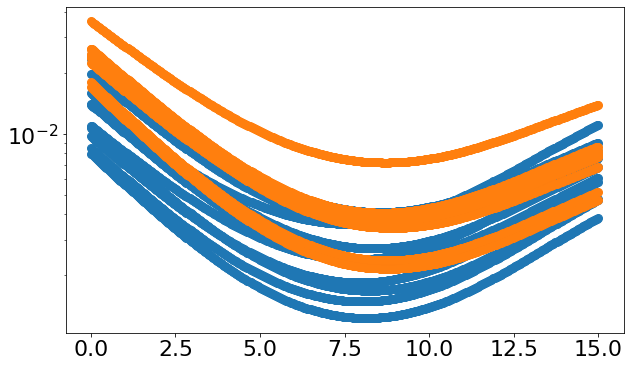

In [24]:
#Input_[:,2]   = np.linspace(0,30,Input_.shape[0])
tVec          = Input_[:,2]
output_Sigma  = Sigmas.predict(Input_)

fig = plt.figure(figsize=(10,6))
plt.plot(tVec, output_Sigma[:,0], 'o')
plt.plot(tVec, output_Sigma[:,1], 'o')
plt.yscale('log')

In [25]:
Input   = {}
Weights = {}
for data_id in InputData.NTrain.keys():
    FileName         = InputData.PathToDataFld + '/train/'+data_id+'/Input.csv'
    Data             = pd.read_csv(FileName)
    Input[data_id]   = Data
    
    FileName         = InputData.PathToRunFld + '/Training/LossWeights/'+data_id+'_9100.csv'
    Data             = pd.read_csv(FileName, header=None)
    Weights[data_id] = Data

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sventuri/WORKSPACE//ROMNet/MSD_100Cases_All/DeepONet_BbB/Deterministic/Run_3//Training/LossWeights/pts_9100.csv'

In [ ]:
#%matplotlib qt

data_id = 'ics'

# fig = plt.figure()
# ax  = fig.add_subplot(projection='3d')
# ax.scatter(Input[data_id]['x'], Input[data_id]['v'], Weights[data_id][1])
# ax.set_xlabel('x')
# ax.set_ylabel('y')

fig = plt.figure()
plt.scatter(Input[data_id]['x'], Weights[data_id][0])
plt.xlabel('x')

fig = plt.figure()
plt.scatter(Input[data_id]['v'], Weights[data_id][1])
plt.xlabel('v')

In [ ]:
%matplotlib qt

data_id = 'res'

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(Input[data_id]['t'], Input[data_id]['x'], Weights[data_id][1])
ax.set_xlabel('t')
ax.set_ylabel('x')

# fig = plt.figure()
# plt.scatter(Input[data_id]['t'], Weights[data_id][0])
# plt.xlabel('t')

# fig = plt.figure()
# plt.scatter(Input[data_id]['t'], Weights[data_id][1])
# plt.xlabel('t')